In [7]:
# Import necessary packages

import numpy as np
import scipy as sp
import skimage as sk

import copy

from statistics import mode

import matplotlib.pyplot as plt

import matplotlib.path as Path
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import minimum_filter, median_filter

import os

import importlib

from PIL import Image

from colour import Color

%matplotlib notebook

In [8]:
import pld
importlib.reload(pld)

<module 'pld' from '/Users/berit/Documents/Papers/2022_RP-mapping_Fleck/Data/Figure 4/Figure 4a/pld.py'>

In [11]:
here = '/Users/berit/Documents/Papers/2022_RP-mapping_Fleck/Data/Figure 4/Figure 4a/' # Directory to file
name = '42_SRO_3-6Mx_12us_1024px.tif' # Image name

filename = here + name

In [12]:
im=Image.open(filename) # Open image
im=np.array(im) # Convert to array
im=im/float(im.max()) # Normalize image intensity
im=im[0:np.min(im.shape), 0:np.min(im.shape)] # Make square

<IPython.core.display.Javascript object>


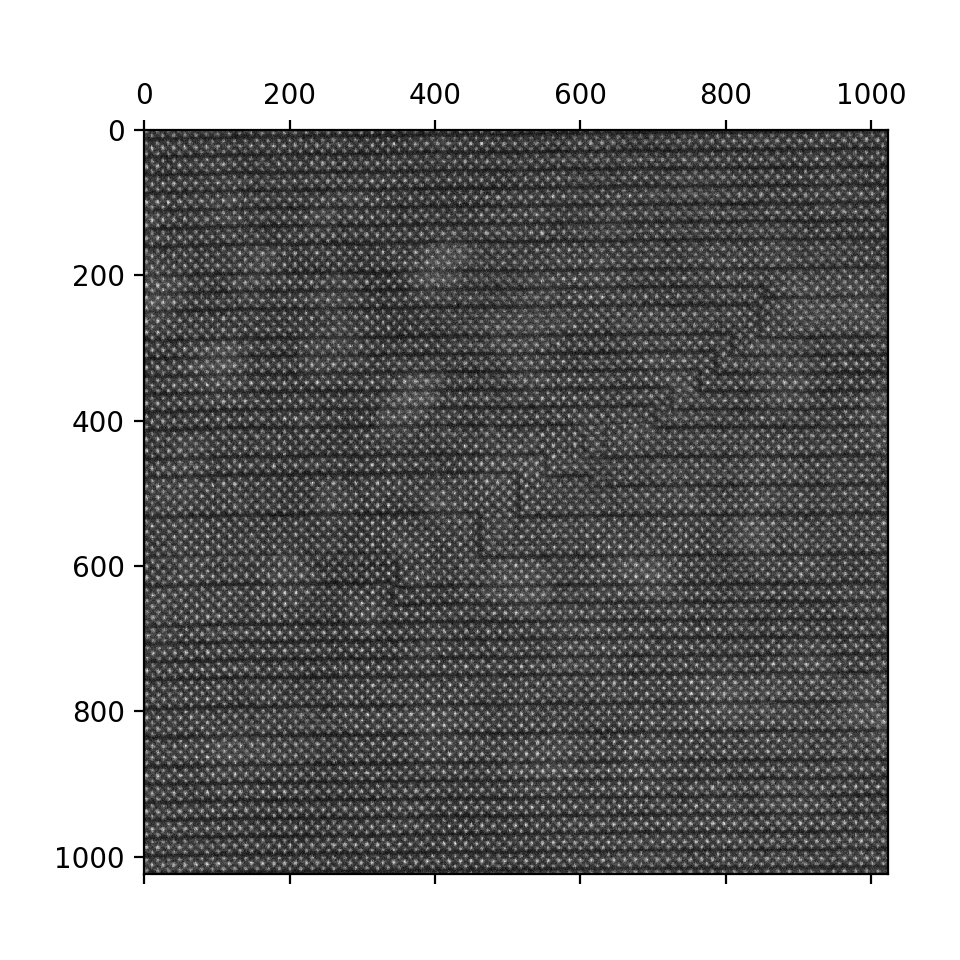

In [13]:
plt.matshow(im, cmap='gray') # Show image

## Fourier Peaks

In [14]:
T=pld.ReciprocalIndex(im)

In [15]:
T._initSuperlatticePeaks('q_x','q_y', 'q_arb') 

### Superlattice peaks

Assume x refers to in-plane, and y refers to out-of-plane.

#### x-direction

In [16]:
# The analysis used for generating the figure had the peak position  at x = 513.2153310104529
# and y = 638.6703832752613. You can try finding this peak yourself or just click 
# a random bright spot in next cell and then simply run the cell after T.q_x.refinePeakPositions

<IPython.core.display.Javascript object>


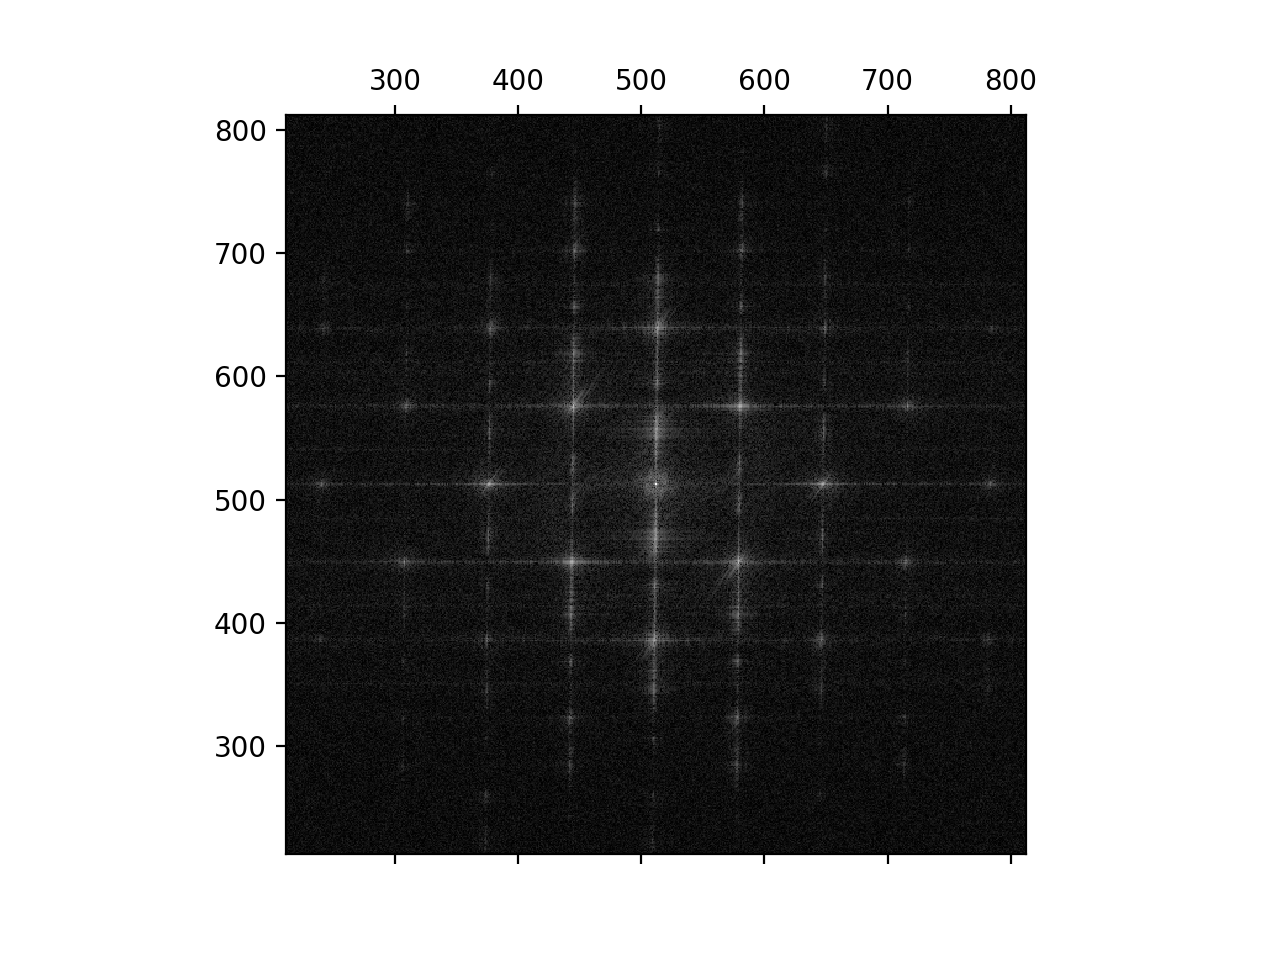

In [17]:
# Click the 020 Bragg spot

T.q_x._clickPeakPosition(zoom=300) # Larger zoom argument -> zoom out; smaller argument -> zoom in


try:
    plt.plot(T.q_x.x,T.q_x.y,'ro') # Plot peaks if any already selectred
except AttributeError:
    pass



In [18]:
T.q_x._appendPeakPosition()  

In [19]:
T.q_x.refinePeakPositions(crop_window=27, track_window=15)

In [20]:
T.q_x.x[-1] = 514.0054362356296
T.q_x.y[-1] = 638.7306835397915

In [21]:
alpha = np.arctan(((im.shape[1]/2)-T.q_x.x[-1])/((im.shape[0]/2)-T.q_x.y[-1])) # Defines angle of sample

## Phase

### x-direction

In [22]:
sigma=35. # Mask size

# Mask size defines real-space coarsening through the below formula
# coarsening (angstrom) = lattice spacing (angstrom) * distance from center of fft to bragg spot / mask size

# Here the coarsening is set to 7.5 A due to the close spacing of RP faults in the n = 1 structure

#If you select too small of a mask size, it may not cover the entire bragg spot and you will not get any sort of useful data
# If the mask is too large, then you will get an image that is too high resolution and includes a lot of noise 

In [23]:
i,label=-1,'020' #Sets fourier point and assigned it a label that can be used in filenaming 
r_dummy= T.Fourier.fourierFilter(T.q_x.x[i],T.q_x.y[i], sigma=sigma)
r=T.Fourier.phaseLockin(T.q_x.x[i],T.q_x.y[i], sigma_x=sigma, sigma_y=sigma)
phase_q_x=(r[0])%(2*np.pi)

In [24]:
T.Fourier.phase=(T.Fourier.phase-np.pi/2.)%(2.*np.pi) # Generates phase map

In [25]:
kx=T.q_x.x[i]-T.im.shape[0]/2. # Generates wavevectors
ky=T.q_x.y[i]-T.im.shape[1]/2.

In [26]:
T.Fourier.get_eps(ky,kx, phase_shift=np.pi/17.) # Generates strain map

In [27]:
eps_xc,eps_xs = T.Fourier.eps_compression.copy(), T.Fourier.eps_shear.copy()

<IPython.core.display.Javascript object>


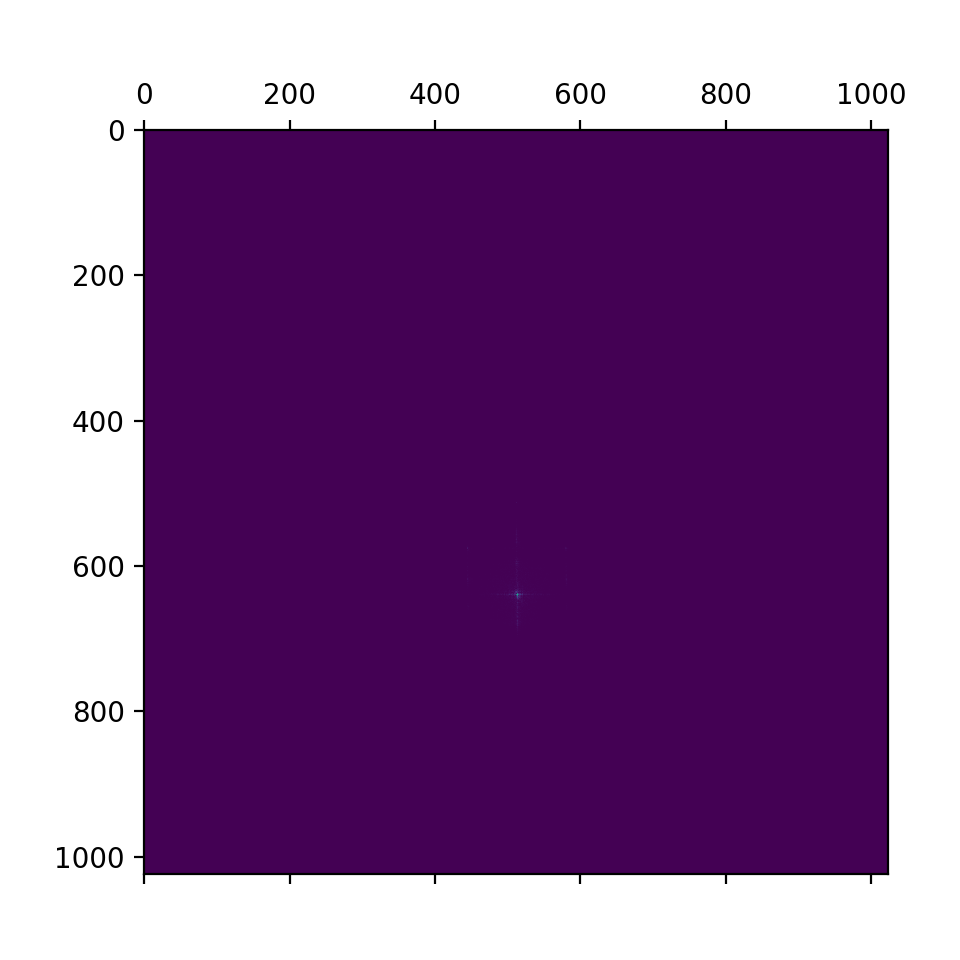

In [28]:
plt.matshow(np.abs(r_dummy[1])) # Shows Fourier component

# To zoom in on masked peak, uncomment following lines.

# plt.xlim((T.q_x.x[i]-im.shape[0]/20, T.q_x.x[i]+im.shape[0]/20))
# plt.ylim((T.q_x.y[i]-im.shape[1]/20, T.q_x.y[i]+im.shape[1]/20))

### Strain

<IPython.core.display.Javascript object>


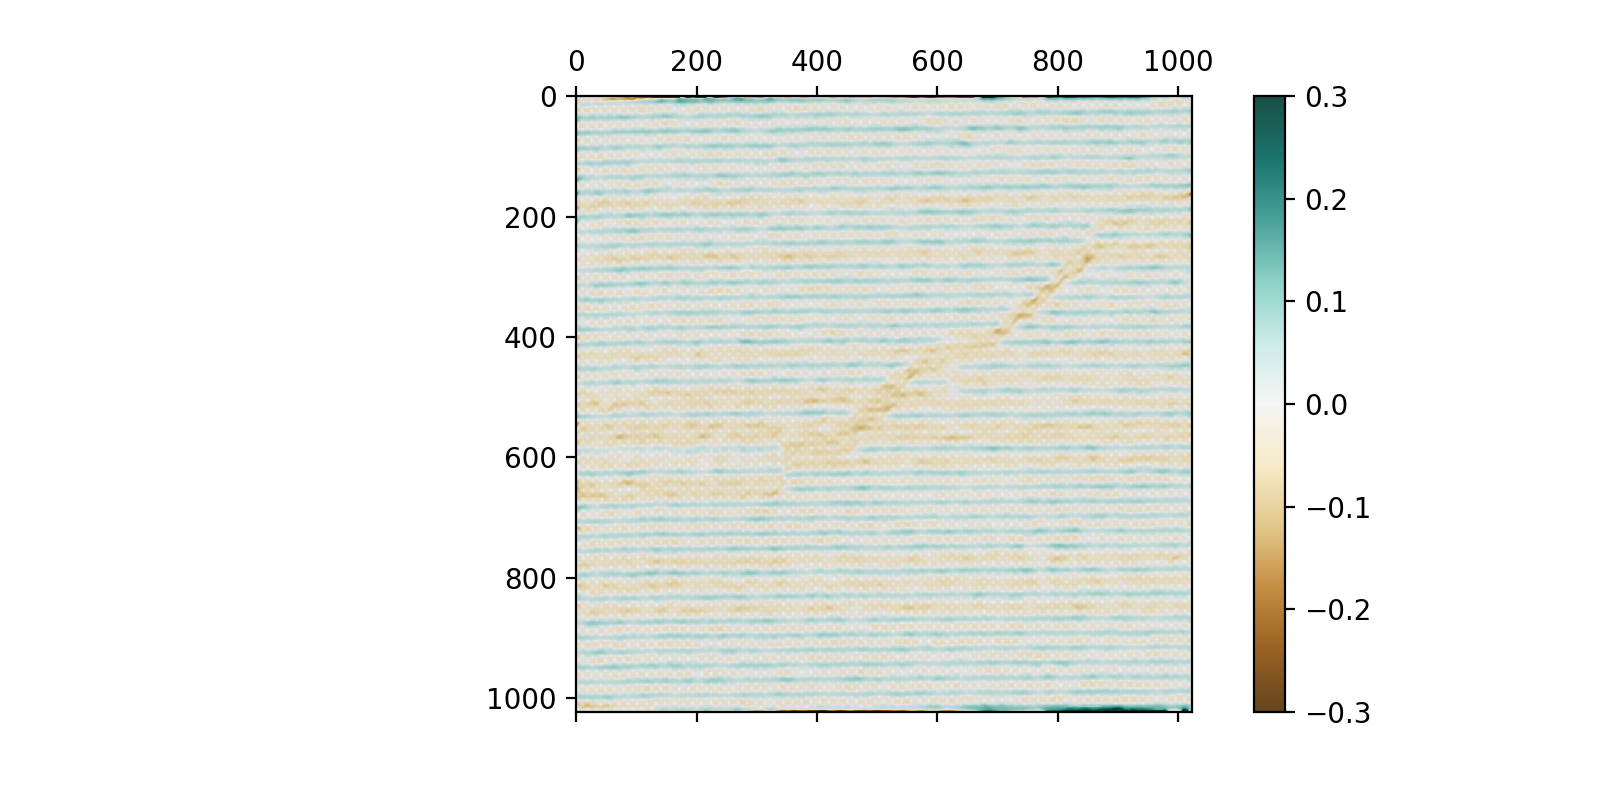

In [29]:
fig, ax =plt.subplots(1, figsize=(8,4), sharex=True, sharey=True)


c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=5), vmin=-0.3, vmax=0.3, cmap='BrBG', alpha = 0.9)

plt.colorbar(c_im0)

<IPython.core.display.Javascript object>


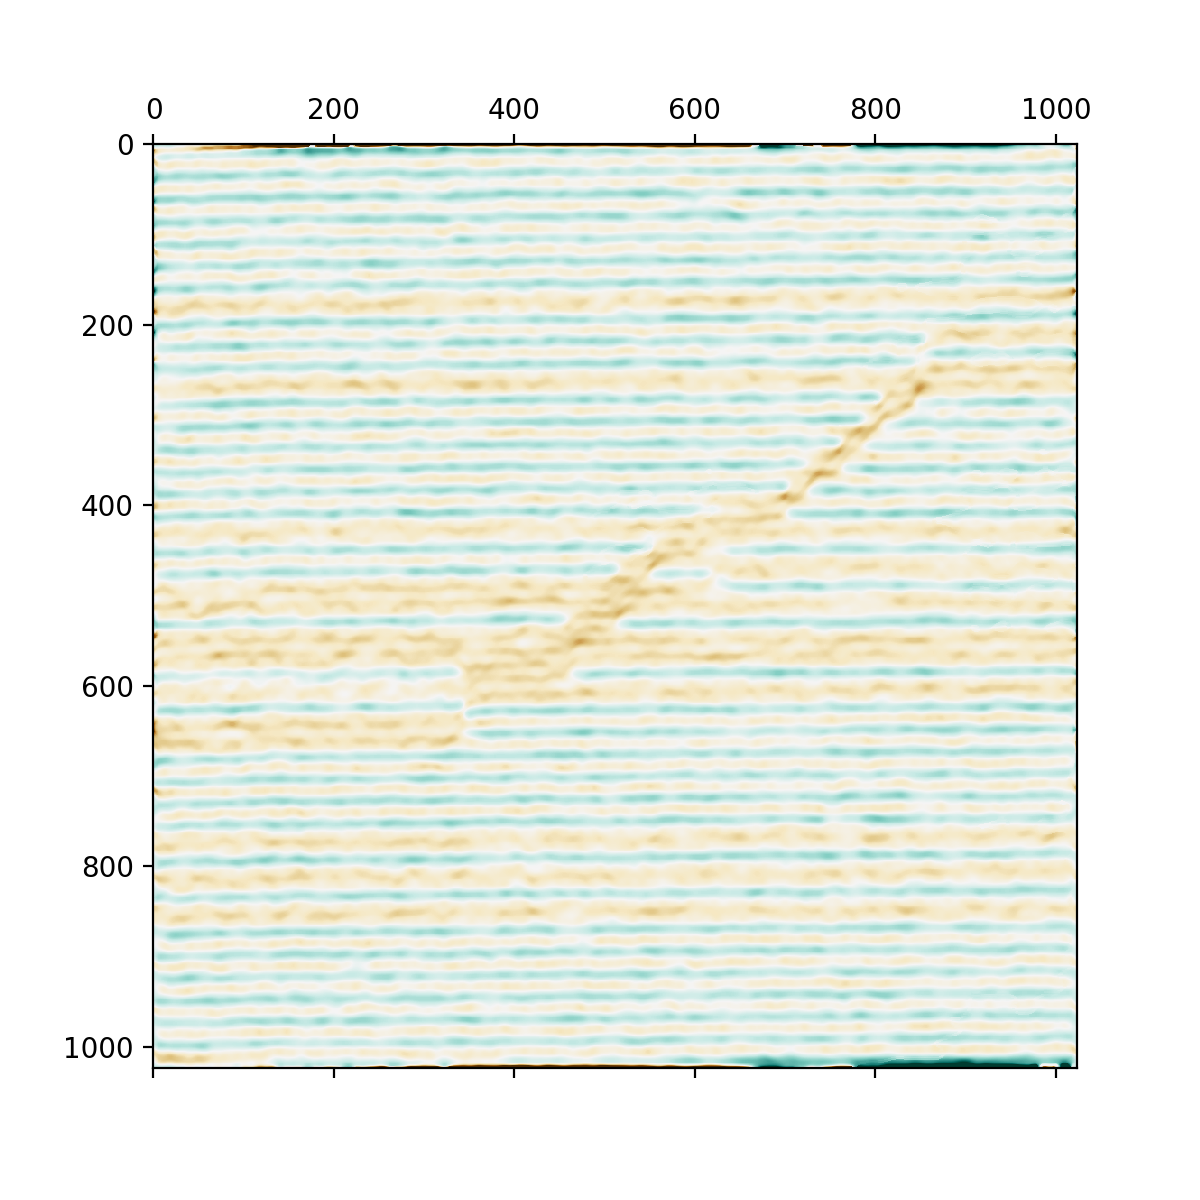

In [30]:
fig, ax =plt.subplots(1, figsize=(6,6), sharex=True, sharey=True)
# c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=5), vmin=-0.25, vmax=0.25, cmap='BrBG')
plt.savefig(here+'Raw-strain.png', bbox_inches = 'tight', transparent = True, dpi = 400)

In [40]:
threshold = 0.02 # The weakest strain that you want to consider as a boundary. 
                 # I recommend finding a solid boundary, and then finding the strain on the edge of it.
                 # This may take some playing around with. 
        
threshold_og = threshold

## Mapping

In [41]:
peak_coords = []

px_scale = np.sqrt((T.q_x.x[-1]-im.shape[1]/2)**2+(T.q_x.y[-1]-im.shape[0]/2)**2)/(2*im.shape[0]) # Defines conversion factor for pixels to local n

spacing = 10 # Sampling rate (e.g. spacing = 5 samples every 5 atomic columns)

scale = int(spacing/px_scale) 

# May want to not look at far ends of images due to edge effects, depends on mapping
left_edge = 0 # Determines distance from left edge of image to stop 
right_edge = 0 # Determines distance from right edge of image to start

for x0 in range(int((int(len(eps_xc[0])-len(eps_xc[1])*np.tan(alpha))))-right_edge): 
    if x0%scale == 0:
        x0 = x0 + left_edge # Set initial x coordinate
        y0 = 10 # Set initial y coordinate
        y1 = (eps_xc.shape[0])-15 # Set final y coordinate
        x1 = int((y1-y0)*np.tan(alpha)+x0) # Set final x coordinate
    
        z = sk.measure.profile_line(image = eps_xc, src = [y0, x0], dst = [y1, x1], linewidth = int(1/(2*px_scale))) # Takes integrated width line profile
        
        num = int(np.sqrt((y1-y0)**2+(x1-x0)**2)) # Find number of samples
        x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num) 
        
        nums = list(range(num))
        xcoords = []
        ycoords = []
        

        # Converts indices in line profile into x and y coordinates of image
        for i in nums:
            xcoords.append((float(i))*(np.sin(alpha))+(x0))
            ycoords.append((float(i))*(np.cos(alpha))+(y0))

        z[z< threshold_og] = 0 # thresholds the data

        
                
        #Width parameter may need to be changed based on the mask size and thresholding.
        #For troubleshooting, somewhere between 1/(2*px_scale) and 1/(10*px_scale) always seems to work
        
        # For sp.signal.find_peaks:
        # z is the interpolated data (the line cut)
        # distance is the minimum distance required before the next peak is counted
        # width is the minimum width required of a peak (if threshold is too low, the width may need to be smaller)
           
        
        peaks, _ = sp.signal.find_peaks(z, distance = 1/(px_scale), width = 1/(4*px_scale)) # Find peaks
      
    
        col = [] # Creates empty array to store this line profile's peaks
        
        for j in range(len(peaks)):
            col.append([int(((float(peaks[j]))*(np.sin(alpha))+(x0))), int((float(peaks[j]))*(np.cos(alpha))+(y0))])
        
        if len(col) >=2 : # If there are two coordinates (i.e. one complete RP)
            peak_coords.append(col)
            
og_peak_coords = copy.deepcopy(peak_coords)


<IPython.core.display.Javascript object>


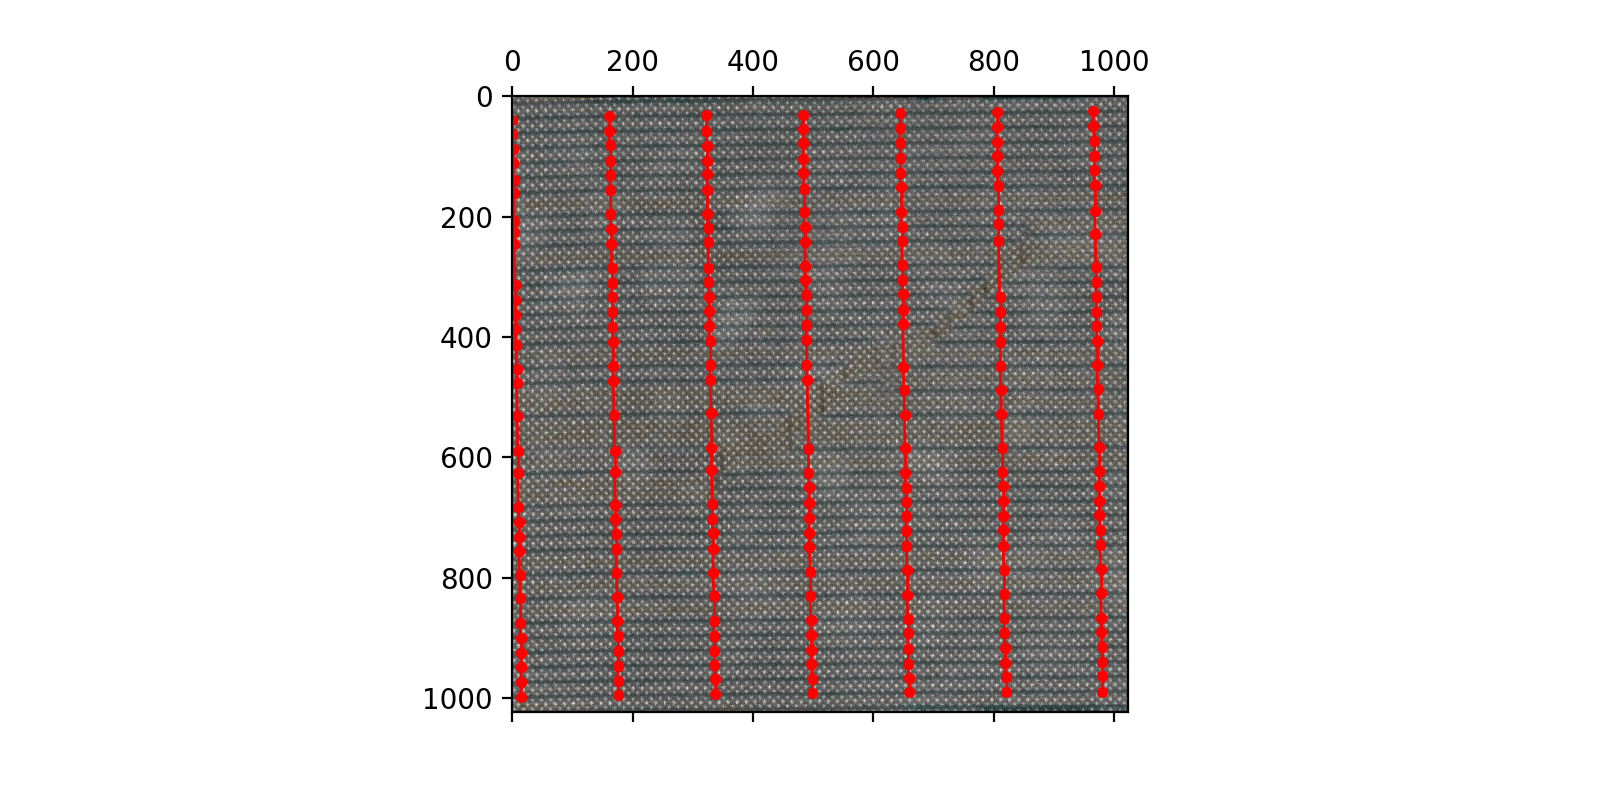

In [42]:
fig, ax =plt.subplots(1, figsize=(8,4), sharex=True, sharey=True)

c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=10), vmin=-0.25, vmax=0.25, cmap='BrBG', alpha = 0.2)

for i in range(len(peak_coords)):
        for j in range(len(peak_coords[i])-1):
           
            px_dist = np.sqrt((peak_coords[i][j][0]-peak_coords[i][j+1][0])**2+(peak_coords[i][j][1]-peak_coords[i][j+1][1])**2) # Distance between peaks in pixels
            almost_uc_dist = px_dist * px_scale # Converts to rough estimate of number of unit cells
            uc_dist = int(np.floor(almost_uc_dist)) # Floors value to obtain integer n phase
        
            #print('n = ' + str(uc_dist)+ ', coords = (' + str(peak_coords[i][j][0]) + ', ' +  str(peak_coords[i][j][1]) + '), ('+ str(peak_coords[i][j+1][0]) + ', ' +  str(peak_coords[i][j+1][1]) + ')')
           
            ax.plot([peak_coords[i][j][0], peak_coords[i][j+1][0]], [peak_coords[i][j][1], peak_coords[i][j+1][1]], 'ro-' ,linewidth = 1, markersize = 3) # Initial plot of counts

In [43]:
xcoords = []
ycoords = []
skewed_top = []
skewed_bottom = []

peak_coords_copy = copy.deepcopy(peak_coords)

for i in peak_coords:
    for j in i:
        xcoords.append(j[0])
        ycoords.append(j[1])
        
# top_cutoff and bottom_cutoff define which "lines" you want to start taking data at.
# This is for the purpose of not biasing the data if it is missing a fault.
# Choose the top and bottom that either make the most sense, or maximize the number of data points (have the most line cuts that start and end on those lines)
# Note the tolerance of this lines can be changed, so for example for smaller crystals this tolerance may need to be lower
    # However this also means that small variations in n would be affected, it will go to the next strain line at least tolerance pixels below the top recorded strain line. 

top_cutoff = 1 # RP fault you want to start data at (starting from topmost at 0)
bottom_cutoff = 0  # RP fault you want to stop data at (starting from bottommost at 0)
                  
tolerance = int(1/px_scale) #anything around within 1 pc lattice unit will be good

for x in range(im.shape[1]):
    skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))])
    skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))])
    for i in range(tolerance):
        skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))+i])
        skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))-i])
        skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))+i])
        skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))-i])


count = 0


while count < top_cutoff:
    peak_coords = copy.deepcopy(peak_coords_copy)
    
    for i in range(len(peak_coords)):
 
        if peak_coords[i][0] in skewed_top:
            
            index = peak_coords_copy.index(peak_coords[i])
            peak_coords_copy[index].remove(peak_coords[i][0])
            xcoords.remove(peak_coords[i][0][0])
            ycoords.remove(peak_coords[i][0][1])
    
    skewed_top = []
    
    for x in range(im.shape[1]):
        skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))])
        for i in range(tolerance):
            skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))+i])
            skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))-i])

    
    count = count + 1

count = 0

while count < bottom_cutoff:
    peak_coords = copy.deepcopy(peak_coords_copy)
    
    for i in range(len(peak_coords)):
 
        if peak_coords[i][-1] in skewed_bottom:
            
            index = peak_coords_copy.index(peak_coords[i])
            peak_coords_copy[index].remove(peak_coords[i][-1])
            xcoords.remove(peak_coords[i][-1][0])
            ycoords.remove(peak_coords[i][-1][1])
    
    skewed_bottom = [] 
    
    for x in range(im.shape[1]):
        skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))])
        for i in range(tolerance):
            skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))+i])
            skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))-i])
    
    count = count + 1

peak_coords_copy2 = copy.deepcopy(peak_coords_copy)


for i in range(len(peak_coords_copy2)): # Remove line cuts that don't hit both the new "top and bottom"
    if peak_coords_copy2[i][0] not in skewed_top or peak_coords_copy2[i][-1] not in skewed_bottom:
        peak_coords_copy.remove(peak_coords_copy2[i])

In [44]:
final_coords = []
uc_dists = []


for i in range(len(peak_coords_copy)):
        for j in range(len(peak_coords_copy[i])-1):
            px_dist = np.sqrt((peak_coords_copy[i][j][0]-peak_coords_copy[i][j+1][0])**2+(peak_coords_copy[i][j][1]-peak_coords_copy[i][j+1][1])**2) 
            ang_dist = px_dist * px_scale
            uc_dist = int((np.floor(ang_dist)))
            #print('n = ' + str(uc_dist)+ ', coords = (' + str(peak_coords_copy[i][j][0]) + ', ' +  str(peak_coords_copy[i][j][1]) + '), ('+ str(peak_coords_copy[i][j+1][0]) + ', ' +  str(peak_coords_copy[i][j+1][1]) + ')')
            uc_dists.append(uc_dist)
            final_coords.append([[peak_coords_copy[i][j][0], peak_coords_copy[i][j][1]], [peak_coords_copy[i][j+1][0], peak_coords_copy[i][j+1][1]]])

<IPython.core.display.Javascript object>


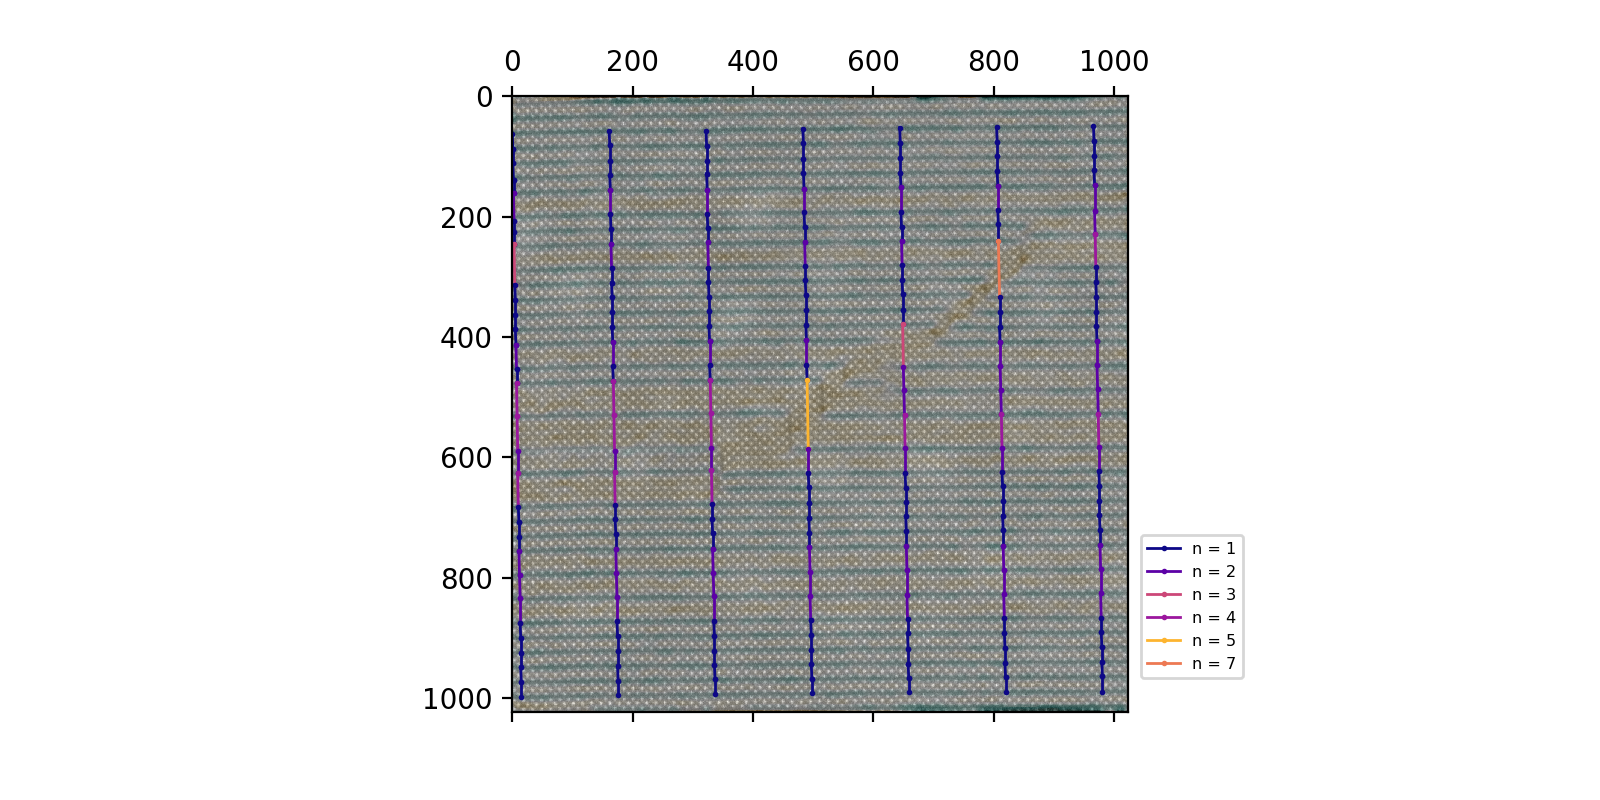

In [45]:
fig, ax =plt.subplots(1, figsize=(8,4), sharex=True, sharey=True)

c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=10), vmin=-0.25, vmax=0.25, cmap='BrBG', alpha = 0.4)

cm = plt.get_cmap('plasma')  
uc_in_order = list(set(uc_dists)) # Creates ordered list
count = len(set(uc_dists)) # Number of different n phases

diff = len(set(uc_dists)) + 1
colors = []


for i in range(len(final_coords)):
    this_color = (uc_in_order.index(uc_dists[i]))*256/(diff-1)
    color = cm(int(this_color))
    colors.append(color)
    ax.plot([final_coords[i][0][0], final_coords[i][1][0]], [final_coords[i][0][1], final_coords[i][1][1]], color = color, marker = 'o' ,linewidth = 1, markersize = 1, label ='n = ' + str(uc_dists[i]))
        
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
ax.legend(handout, sorted(lablout), fontsize = 'xx-small', bbox_to_anchor=(1.2,0.3))

In [46]:
uc_dists_edited = uc_dists.copy() # Makes copy of n to be edited if small errors occur

# If certain n must be edited but the error appears to not be systematic (i.e. only here and there n is 
# off by ~1), then the list of n can be printed and the associated uc_dist index can be manually modified.
# To remove a given n, set the value corresponding to its index equal to 0.

# All of the n can be found by uncommenting the following lines:

# i = 0
# for coords in final_coords:
#         print(" Index " + str(i) + ": n = " + str(uc_dists[i]) + " with starting, ending coordinates " + str(coords))
#         i = i + 1


uc_in_order = list(set(uc_dists_edited)) 
count = len(set(uc_dists_edited))

# This won't change the mapping, just the quantitative results. If the mapping seems off, 
# try playing around with other parameters first, then as last result you can edit 
# entries of final_coords, with a bit of effort .

## Final results

<IPython.core.display.Javascript object>


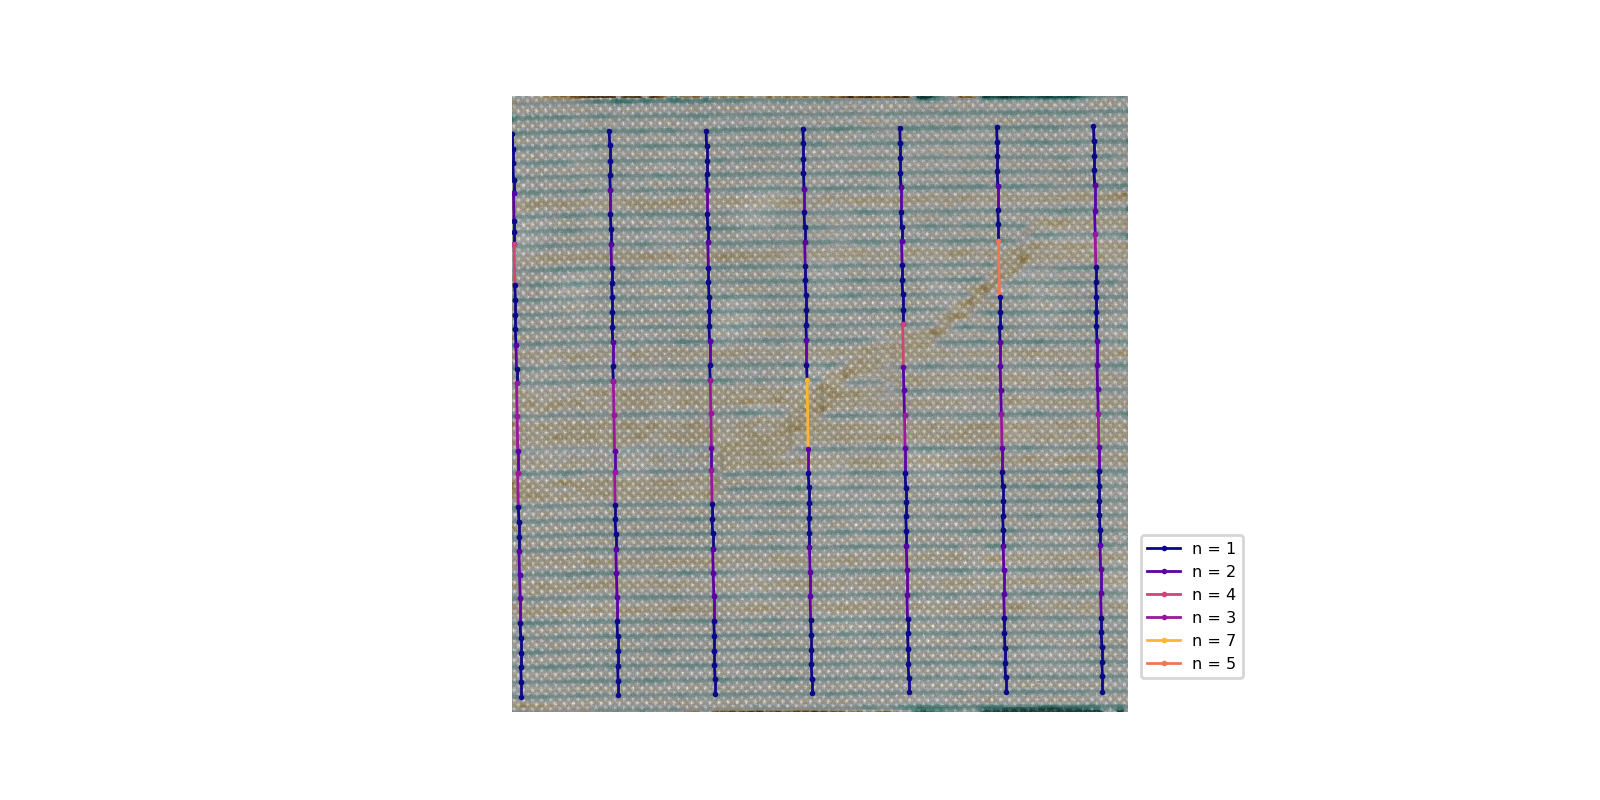

(-0.5, 1023.5, 1023.5, -0.5)

In [47]:
fig, ax =plt.subplots(1, figsize=(8,4), sharex=True, sharey=True)

c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=10), vmin=-0.25, vmax=0.25, cmap='BrBG', alpha = 0.5)

diff = len(set(uc_dists_edited)) + 1



cm = plt.get_cmap('plasma')  
colors = []


for i in range(len(final_coords)):
    if uc_dists_edited[i] != 0:
        this_color = (uc_in_order.index(uc_dists[i]))*256/(diff-1)
        color = cm(int(this_color))
        if colors.count(color) == 0:
            colors.append(color)
        ax.plot([final_coords[i][0][0], final_coords[i][1][0]], [final_coords[i][0][1], final_coords[i][1][1]], color = color, marker = 'o' ,linewidth = 1, markersize = 1, label ='n = ' + str(uc_dists_edited[i]))


hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
ax.legend(handout, lablout, fontsize = 'xx-small', bbox_to_anchor=(1.2,0.3))

ax.axis("off")

<IPython.core.display.Javascript object>


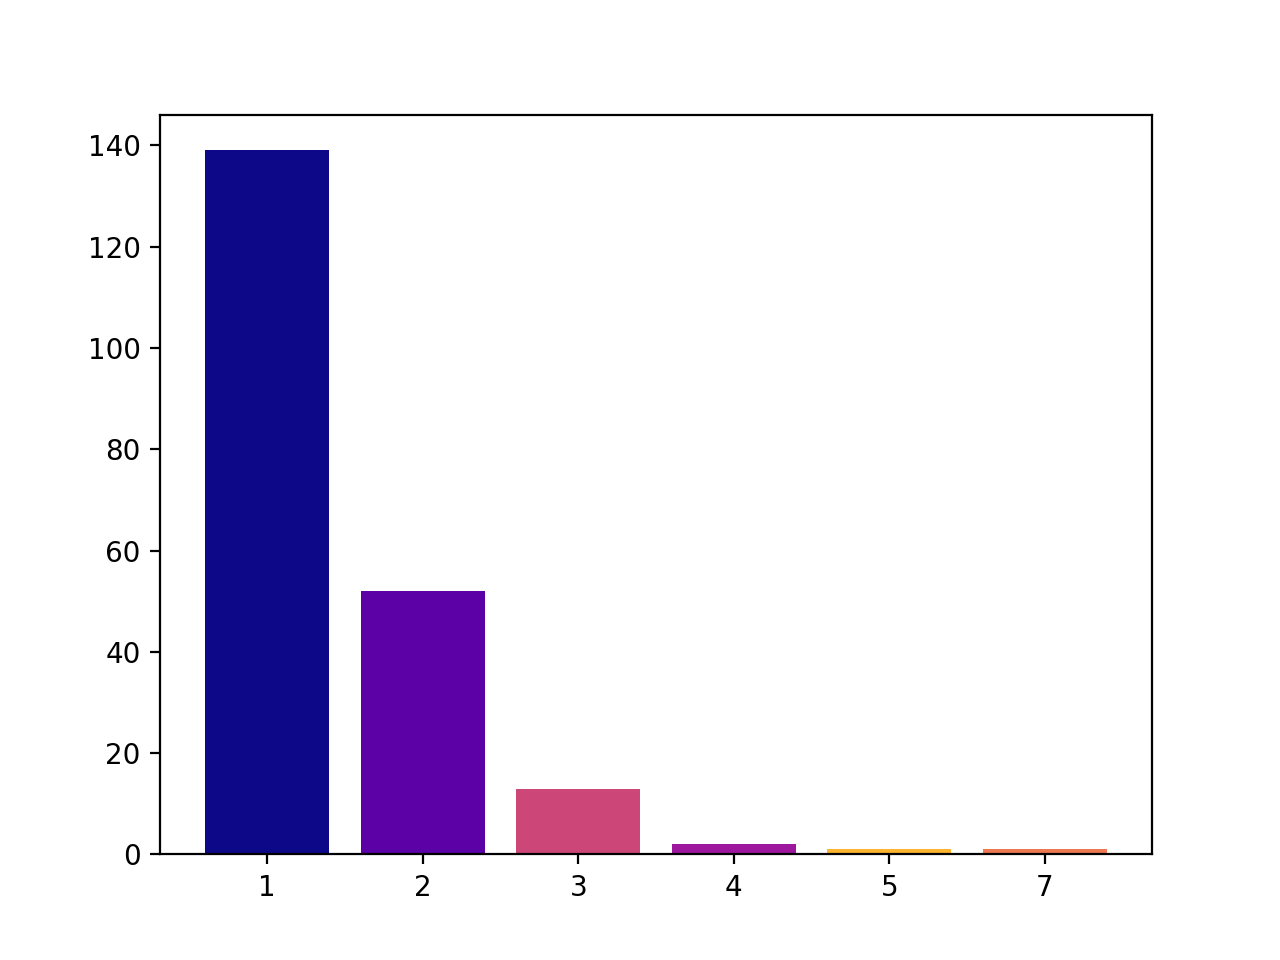

[1 2 3 4 5 7]
[139  52  13   2   1   1]


In [48]:
fig, ax = plt.subplots(nrows=1)

while uc_dists_edited.count(0) > 0:
    uc_dists_edited.remove(0)
    
    
u, counts = np.unique(uc_dists_edited, return_counts=True)
print(u)
print(counts) 

for i in range(len(final_coords)):
    if uc_dists_edited[i] != 0:
        this_color = (uc_in_order.index(uc_dists[i]))*256/(diff-1)

plt.bar(np.arange(len(u)), counts, color = colors)
plt.xticks(np.arange(len(u)), u)
plt.show()